In [34]:
%matplotlib notebook
import importlib
from matplotlib import pyplot as plt
from input_encoding.population_coding.utils import gaussian, gen_population_coding
import lvq.lvq1
from lvq.lvq1 import LVQ1
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from som import SOM

importlib.reload(lvq.lvq1)
from lvq.lvq1 import LVQ1

In [2]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/filtered_coil20.npy', 'rb') as f:
    filtered = np.load(f, allow_pickle=True)

In [2]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/coil20_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [3]:
with open('C:/Users/ehajizad/lava-nc/neuromorphic-continual-learning/tutorials/strided_coil20.npy', 'rb') as f:
    stride_filtered = np.load(f, allow_pickle=True)

In [4]:
scaled_input = 100 * stride_filtered
scaled_input = scaled_input.reshape((scaled_input.shape[0], stride_filtered.shape[1],-1))
print(scaled_input.shape)
flat_input=scaled_input.reshape((scaled_input.shape[0], -1))
print(flat_input.shape)

(1440, 8, 441)
(1440, 3528)


In [5]:
# Bound the feature to the [0,200] range simulating the rate code range
bounded = scaled_input.copy()
bounded[bounded<30]=0  # below 10, no spike
bounded[bounded>200]=200 # above 200, rate code saturates

# Calculate the noise value for each patch
sum_per_patch = bounded.sum(1)
noise = 150 - sum_per_patch
noise[noise<0]=0 # also bounded in the range of [0,200]

# Append this noise feature to our feature vectors
bounded=np.append(bounded, noise[:,np.newaxis, :], axis=1)
print(bounded.shape) # new noise feature is now added

flat_bounded=bounded.reshape((bounded.shape[0], bounded.shape[1]*bounded.shape[2]))
print(flat_bounded.shape)

(1440, 9, 441)
(1440, 3969)


<IPython.core.display.Javascript object>


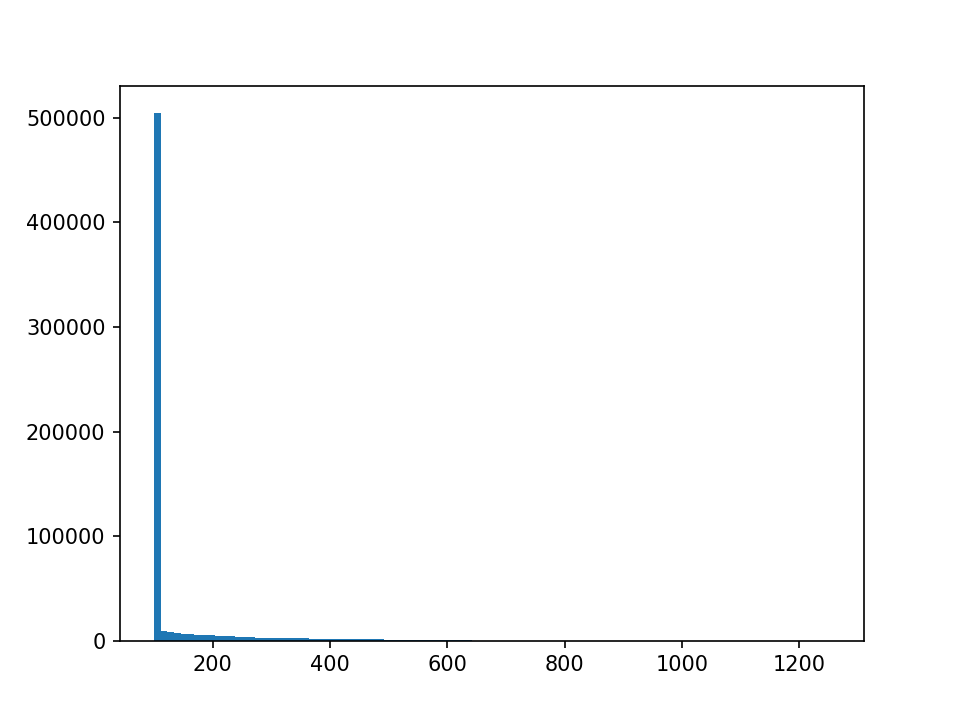

In [32]:
# now mostly the activation per patch is the same
sum_per_patch = bounded.sum(1)
plt.figure()
plt.hist(sum_per_patch.flatten(),100)
plt.show()

<IPython.core.display.Javascript object>


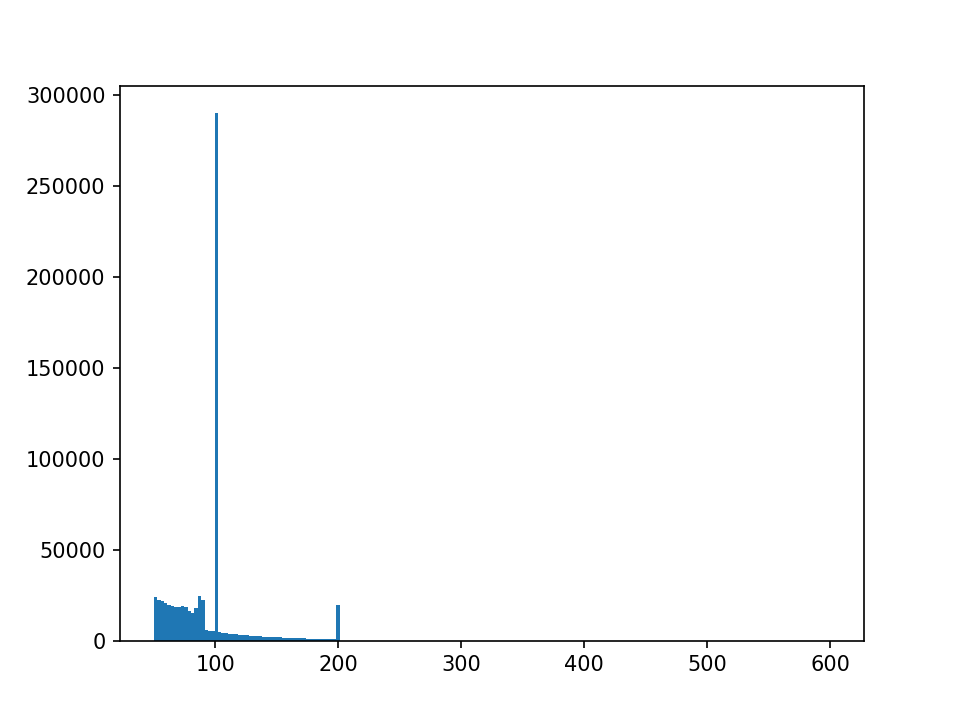

In [33]:
plt.figure()
plt.hist(bounded.flatten(),200, [50,600])
plt.show()

<IPython.core.display.Javascript object>


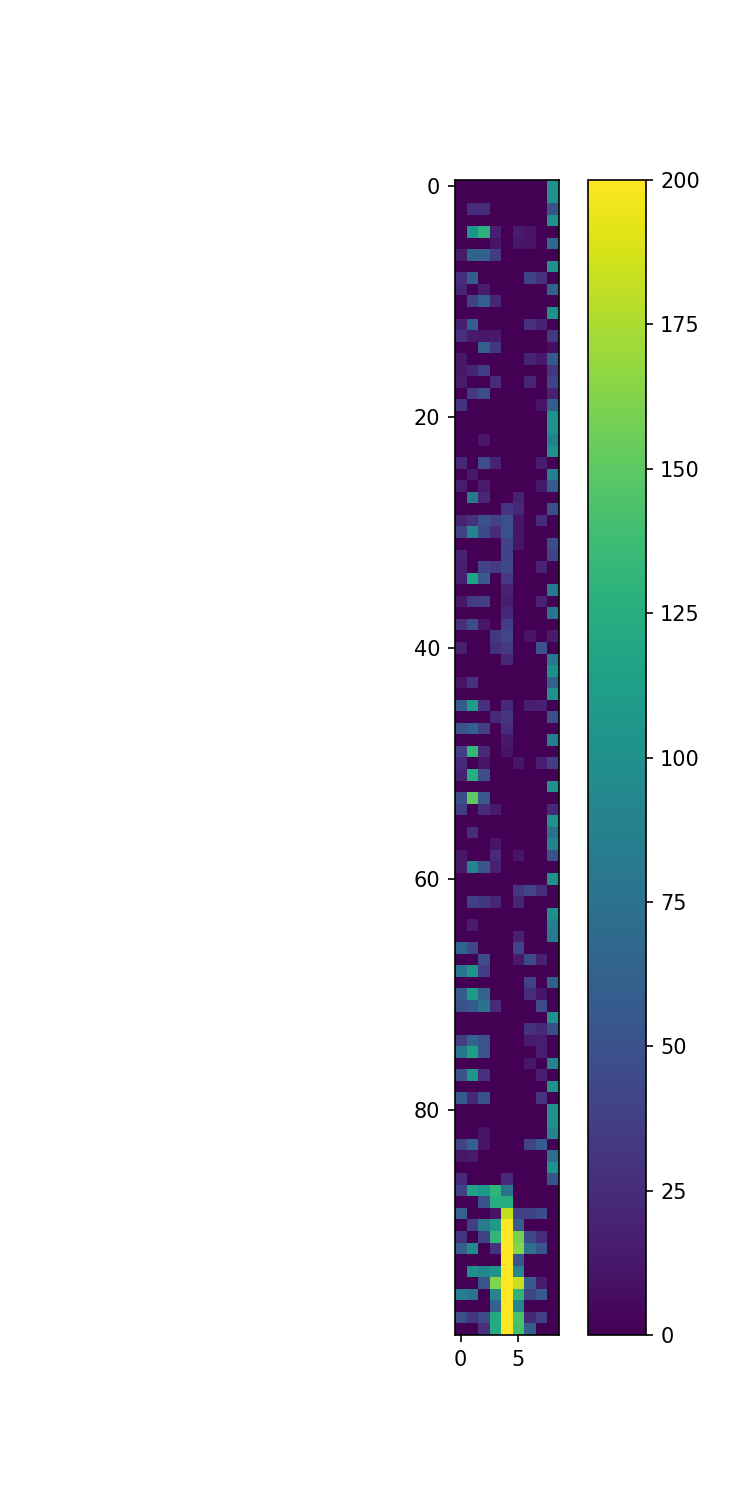

In [37]:
plt.figure(figsize=(5,10))
plt.imshow(bounded[145,:,:100].T)
plt.colorbar()
plt.show()

In [114]:
from scipy.spatial.distance import pdist, squareform

def min_max_scale(data):
    d_min = data.min()
    d_max = data.max()
    return (data-d_min)/(d_max-d_min)

input_feat = stride_filtered
flat_input_feat = stride_filtered.reshape((stride_filtered.shape[0], -1))

# euclidian distance similarity for population coded data
distances = pdist(flat_input_feat, metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix = min_max_scale(dist_matrix)
euc_sim_pc = 1/np.exp(dist_matrix)


# dot product similarity on u_data_flat_scaled
u_data_sim = np.matmul(flat_input_feat,flat_input_feat.T)
u_data_sim_sc = min_max_scale(u_data_sim)

v_th=400
u_data_th1 = np.copy(u_data_sim)
u_data_th1[u_data_th1>=v_th] = v_th
u_data_th1_sc = min_max_scale(u_data_th1)

<IPython.core.display.Javascript object>


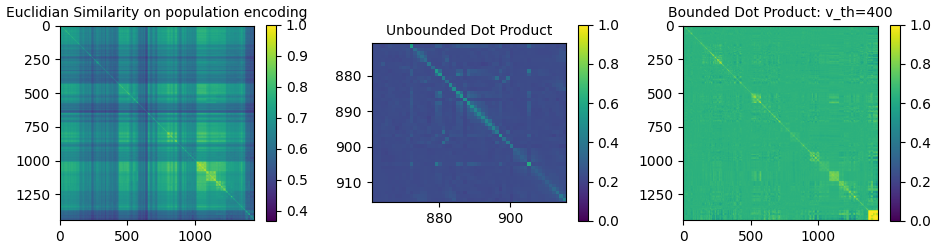

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9.5,2.5))

im1 = ax1.imshow(euc_sim_pc)
im2 = ax2.imshow(u_data_sim_sc)
im3 = ax3.imshow(u_data_th1_sc)
ax1.set_title("Euclidian Similarity on population encoding", fontsize=10)
ax2.set_title("Unbounded Dot Product", fontsize=10)
ax3.set_title("Bounded Dot Product: v_th=400", fontsize=10)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


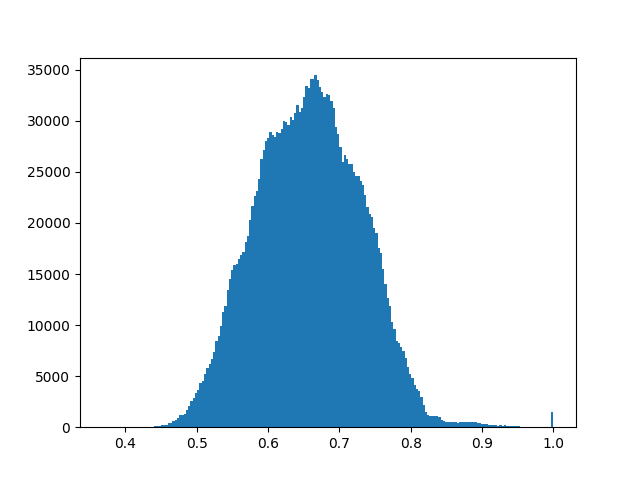

In [94]:
plt.figure()
plt.hist(euc_sim_pc.flatten(),200)
plt.show()

<IPython.core.display.Javascript object>


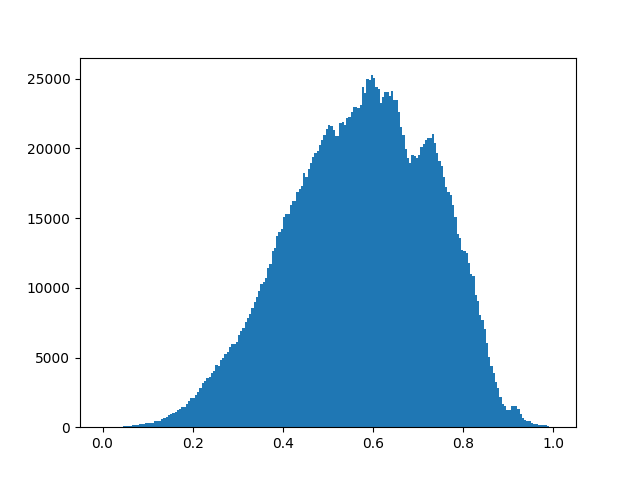

In [95]:
plt.figure()
plt.hist(u_data_sim_sc.flatten(),200)
plt.show()

In [92]:
importlib.reload(lvq.lvq1)
from lvq.lvq1 import LVQ1

n_epochs = 40
alpha = 0.03
alpha_decay = 'hill'
n_protos_per_class = 12
n_class = 20

X = flat_bounded
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

mlvq2 = LVQ1(bmu_metric='euclidean', random_protos=True, alpha_decay=alpha_decay,
             n_protos_per_class=n_protos_per_class, 
             n_class=n_class)
mlvq2.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                       alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)
mlvq2.predict(X_test, y_test)

mlvq3 = LVQ1(bmu_metric='dot_product', random_protos=True, alpha_decay=alpha_decay,
             n_protos_per_class=n_protos_per_class, 
             n_class=n_class)
mlvq3.train_prototypes(x_train=X_train, y_train=y_train, x_test=X_test , y_test=y_test,
                       alpha_start=alpha, n_epochs=n_epochs, test_each_epoch=True)
mlvq3.predict(X_test, y_test)



example_protos = flat_bounded[np.concatenate([np.arange(n_protos_per_class)+72*n for n in range(n_class)]),:]
# mlvq2 = LVQ1(bmu_metric='euclidean', random_protos=False, alpha_decay=alpha_decay,
#              n_protos_per_class=n_protos_per_class, 
#              n_class=n_class,
#              init_protos=np.copy(example_protos))
# mlvq2.train_prototypes(data=flat_bounded, targets=labels, alpha_start=alpha, n_epochs=n_epochs)




Initial prototypes:
 [[ -3.6   3.2   7.9 ...  88.9 145.5 125.2]
 [-24.6  -6.2   9.5 ... 136.9 121.3 154. ]
 [ -5.7   9.2 -22.1 ... 193.1 124.  158.2]
 ...
 [ -9.6 -11.8  -4.  ... 144.7 177.4 155.8]
 [  5.7  21.7  10.7 ... 122.7 110.1 137.2]
 [ -9.    1.9  -3.4 ... 138.1 132.8 145.7]]
>epoch=0, lrate=0.030, error=2544394.719, tr_err=0.826, test_err=0.771
>epoch=1, lrate=0.030, error=2471602.361, tr_err=0.603, test_err=0.542
>epoch=2, lrate=0.030, error=2361079.407, tr_err=0.473, test_err=0.458
>epoch=3, lrate=0.030, error=2264730.837, tr_err=0.403, test_err=0.417
>epoch=4, lrate=0.030, error=2182858.579, tr_err=0.373, test_err=0.377
>epoch=5, lrate=0.030, error=2058070.364, tr_err=0.323, test_err=0.331
>epoch=6, lrate=0.030, error=1946407.677, tr_err=0.302, test_err=0.336
>epoch=7, lrate=0.030, error=1849614.694, tr_err=0.280, test_err=0.312
>epoch=8, lrate=0.029, error=1789887.306, tr_err=0.255, test_err=0.282
>epoch=9, lrate=0.029, error=1746952.280, tr_err=0.240, test_err=0.269
>epoc

<IPython.core.display.Javascript object>


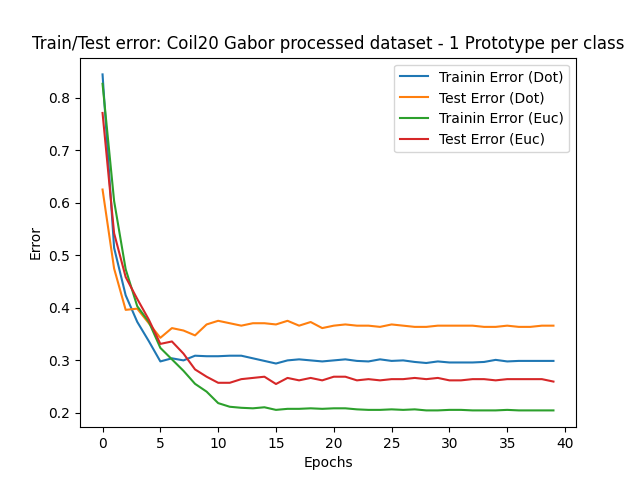

Text(0.5, 1.0, 'Train/Test error: Coil20 Gabor processed dataset - 1 Prototype per class')

In [93]:
plt.figure()
plt.plot(mlvq3.train_errors)
plt.plot(mlvq3.test_errors)
plt.plot(mlvq2.train_errors)
plt.plot(mlvq2.test_errors)

plt.legend(["Trainin Error (Dot)", 
            "Test Error (Dot)",
            "Trainin Error (Euc)", 
            "Test Error (Euc)"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Train/Test error: Coil20 Gabor processed dataset - 1 Prototype per class")

<IPython.core.display.Javascript object>


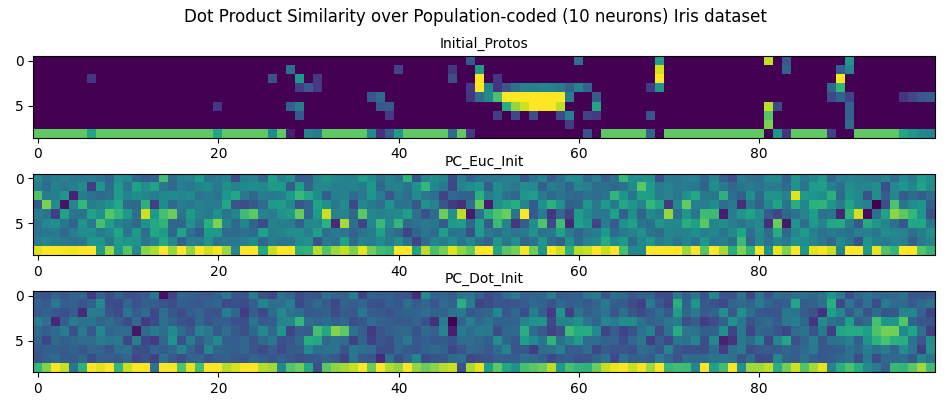

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9.5,4))
proto_ind = 60
ind_max = 100
im1 = ax1.imshow(example_protos[proto_ind,:].reshape((9,441))[:,:100])
im2 = ax2.imshow(mlvq2.prototypes[proto_ind,:].reshape((9,441))[:,:100])
im3 = ax3.imshow(mlvq3.prototypes[proto_ind,:].reshape((9,441))[:,:100])
ax1.set_title("Initial_Protos", fontsize=10)
ax2.set_title("PC_Euc_Init", fontsize=10)
ax3.set_title("PC_Dot_Init", fontsize=10)
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)
# fig.colorbar(im3, ax=ax3)
fig.suptitle("Dot Product Similarity over Population-coded (10 neurons) Iris dataset")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


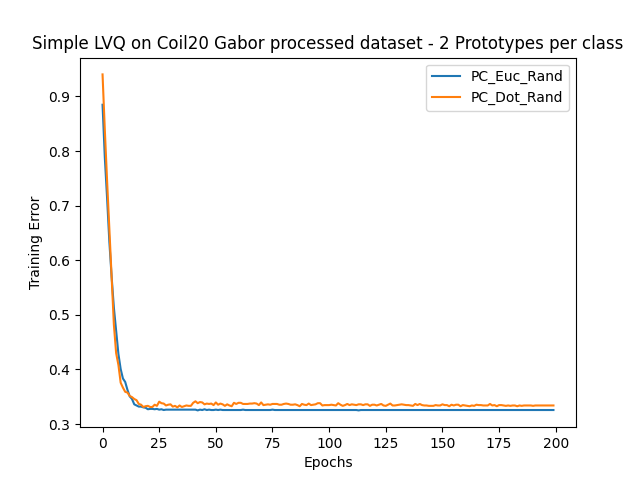

Text(0.5, 1.0, 'Simple LVQ on Coil20 Gabor processed dataset - 2 Prototypes per class')

In [16]:
plt.figure()
plt.plot(mlvq2.inf_errors)
plt.plot(mlvq3.inf_errors)

plt.legend(["PC_Euc_Rand", 
            "PC_Dot_Rand"])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Simple LVQ on Coil20 Gabor processed dataset - 2 Prototypes per class")

<IPython.core.display.Javascript object>


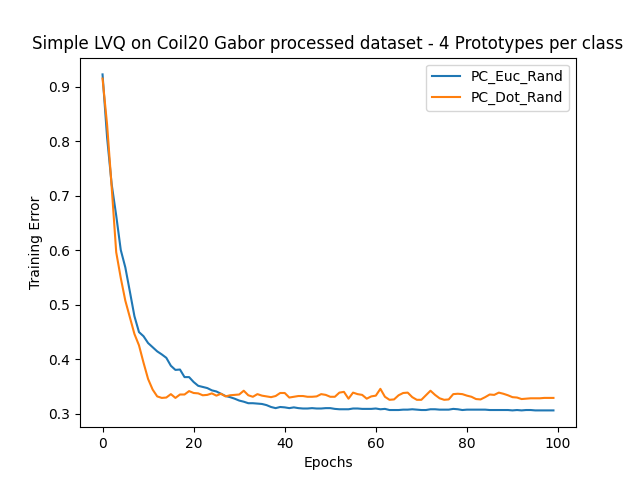

Text(0.5, 1.0, 'Simple LVQ on Coil20 Gabor processed dataset - 4 Prototypes per class')

In [20]:
plt.figure()
plt.plot(mlvq2.inf_errors)
plt.plot(mlvq3.inf_errors)

plt.legend(["PC_Euc_Rand", 
            "PC_Dot_Rand"])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Simple LVQ on Coil20 Gabor processed dataset - 4 Prototypes per class")

<IPython.core.display.Javascript object>


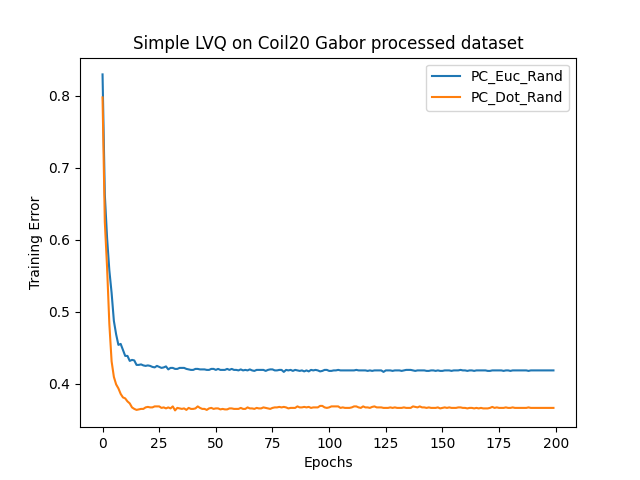

Text(0.5, 1.0, 'Simple LVQ on Coil20 Gabor processed dataset')

In [12]:
plt.figure()
plt.plot(mlvq2.inf_errors)
plt.plot(mlvq3.inf_errors)

plt.legend(["PC_Euc_Rand", 
            "PC_Dot_Rand"])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Simple LVQ on Coil20 Gabor processed dataset - 1 Prototype per class")